In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Sep  3 09:58:08 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   43C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

Not using a high-RAM runtime


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install transformers

In [ ]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, f1_score, precision_score, recall_score
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW, get_linear_schedule_with_warmup
import torch
from torch.utils.data import DataLoader, TensorDataset, RandomSampler, SequentialSampler
import torch.nn.functional as F
from tqdm import trange, tqdm
import matplotlib.pyplot as plt
import sklearn.utils
import time
import re


In [ ]:
# Retrive the data from stored dataset
dataDir = "/content/drive/MyDrive/WoS/data"
tsvData = os.path.join(dataDir,"WoSDataset_5736.tsv")

tsvData = np.loadtxt(tsvData, dtype=str, delimiter="\t")
print(np.shape(tsvData))

(5736, 4)


In [ ]:
print(tsvData[0:15])

[['2' 'biochemistry'
  ' candidatus phytoplasma    16s rrna biosecurity taxonomy biodiversity vector seed transmission host range       '
  'phytoplasmas are insectvectored bacteria that cause disease in a wide range of plant species the increasing availability of molecular dna analyses expertise and additional methods in recent years has led to a proliferation of discoveries of phytoplasmaplant host associations and in the numbers of taxonomic groupings for phytoplasmas the widespread use of common names based on the diseases with which they are associated as well as separate phenetic and taxonomic systems for classifying phytoplasmas based on variation at the 16s rrnaencoding gene complicates interpretation of the literature we explore this issue and related trends through a focus on australian pathosystems providing the first comprehensive compilation of information for this continent covering the phytoplasmas host plants vectors and diseases of the 33 16sr groups reported internati

In [ ]:
allLabels = tsvData[:,0]
domains = tsvData[:,1]
keywords = tsvData[:,2]
abstracts = tsvData[:,3]

In [ ]:
labels = np.unique(domains, return_counts=True)[0]
labelCounts=  np.unique(domains, return_counts=True)[1]

print("Labels ", labels)
print("Label counts ", labelCounts)

Labels  ['ECE' 'Psychology' 'biochemistry']
Label counts  [1292 1597 2847]


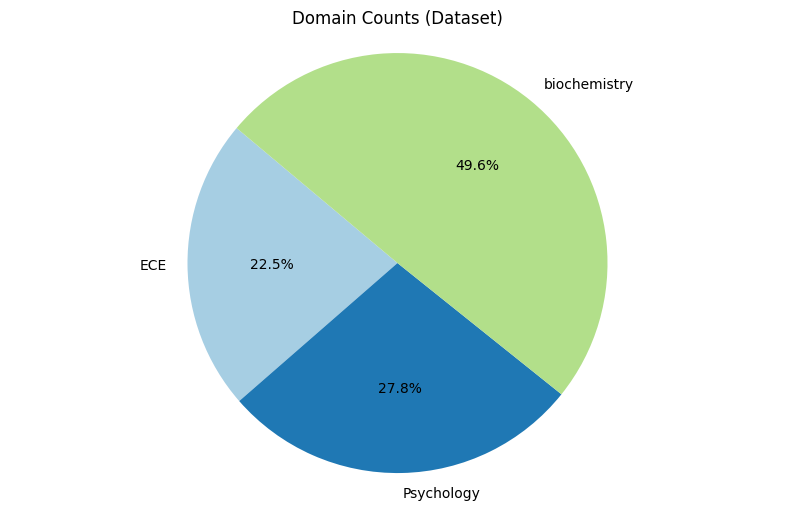

The domain ECE has 1292 records in the dataset.
The domain Psychology has 1597 records in the dataset.
The domain biochemistry has 2847 records in the dataset.


In [ ]:
# Visualize domain counts in dataset
plt.figure(figsize=(10, 6))
plt.title("Domain Counts (Dataset)")
plt.pie(labelCounts, labels=labels, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired(range(len(labels))))
plt.axis('equal')
plt.show()

for i, domain in enumerate(labels):
    print("The domain", domain, "has", labelCounts[i], "records in the dataset.")

In [ ]:
# Shuffle data
dataShuffled = sklearn.utils.shuffle(tsvData)

abstractsShuffled = dataShuffled[:,3]
keywordsShuffled = dataShuffled[:,2]
domainsShuffled = dataShuffled[:,1]
allLabelsShuffled = dataShuffled[:,0]

print("Number of abstracts: ", len(abstractsShuffled))
print("Shape of abstracts: ", np.shape(abstractsShuffled))
print(abstractsShuffled[0:2])

print("Number of keywords: ", len(keywordsShuffled))
print("Shape of keywords: ", np.shape(keywordsShuffled))
print(abstractsShuffled[0:2])

print("Number of domains: ", len(domainsShuffled))
print("Shape of domains: ", np.shape(domainsShuffled))
print(domainsShuffled[0:2])

print("Number of labels: ", len(allLabelsShuffled))
print("Shape of labels: ", np.shape(allLabelsShuffled))
print(allLabelsShuffled[0:2])


# Convert labels to integer
allLabelsDigitShuffled = allLabelsShuffled.astype(int)

print(abstractsShuffled[0:10])
print(keywordsShuffled[0:10])
print(domainsShuffled[0:10])
print(allLabelsShuffled[0:10])
print(allLabelsDigitShuffled[0:10])

Number of abstracts:  5736
Shape of abstracts:  (5736,)
['meat adulteration has posed considerable risks to public health in this study we developed a novel realtime quantitative pcr method for the detection of some mammalian and poultry species that are used as meat products or meat adulterants the method was based on the detection of the singlecopy nuclear gene myostatin the specificity heterogeneity and copy number of myostatin were evaluated additionally we determined the sensitivity and precision of the method the results revealed that myostatin had high specificity and low heterogeneity among different mammalian and poultry species the limit of detection was 5 pg of animal genomic dna or 0001 meat ingredient and the limit of quantification was 10 pg of animal genomic dna or 001 meat ingredient the quantification results of 12 blind samples showed that the biases between the measured and true values were 25 therefore the developed quantitative realtime pcr method for mammalian and

In [ ]:
# Split dataset into training and testing (80/20 split)
train_data, test_data = train_test_split(dataShuffled, test_size=0.2, random_state=42)
print(np.shape(train_data))
print(np.shape(test_data))

# Further split training data into training and validation (80/20 split of training set)
_, val_data = train_test_split(test_data, test_size=0.2, random_state=42)
print(np.shape(train_data))
print(np.shape(test_data))
print(np.shape(val_data))
# Load SciBERT tokenizer
tokenizer = AutoTokenizer.from_pretrained("allenai/scibert_scivocab_uncased")

(4588, 4)
(1148, 4)
(4588, 4)
(1148, 4)
(230, 4)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/228k [00:00<?, ?B/s]

In [ ]:
abstractsTrain = train_data[:,3]
keywordsTrain = train_data[:,2]
domainsTrain = train_data[:,1]
allLabelsTrain = train_data[:,0]

print("Number of abstracts: ",len(abstractsTrain))
print("Shape of abstracts: ",np.shape(abstractsTrain))
print("Number of keywords: ",len(keywordsTrain))
print("Shape of keywords: ",np.shape(keywordsTrain))
print("Number of domains: ",len(domainsTrain))
print("Shape of domains: ",np.shape(domainsTrain))
print("Number of labels: ",len(allLabelsTrain))
print("Shape of labels: ",np.shape(allLabelsTrain))

print(abstractsTrain[0:2])
print(keywordsTrain[0:2])
print(domainsTrain[0:2])
print(allLabelsTrain[0:2])

Number of abstracts:  4588
Shape of abstracts:  (4588,)
Number of keywords:  4588
Shape of keywords:  (4588,)
Number of domains:  4588
Shape of domains:  (4588,)
Number of labels:  4588
Shape of labels:  (4588,)
['the alignment of many short sequences of dna called reads to a long reference genome is a common task in molecular biology when the problem is expanded to handle typical workloads of billions of reads execution time becomes critical in this paper we present a novel reconfigurable architecture for minimal perfect sequencing ramps while existing solutions attempt to align a high percentage of the reads using a small memory footprint ramps focuses on performing fast exact matching using the human genome as a reference ramps aligns short reads hundreds of thousands of times faster than current software implementations such as soap2 or bowtie and about a thousand times faster than gpu implementations such as soap3 whereas other aligners require hours to preprocess reference genome

Labels  ['ECE' 'Psychology' 'biochemistry']
Label counts  [1030 1280 2278]


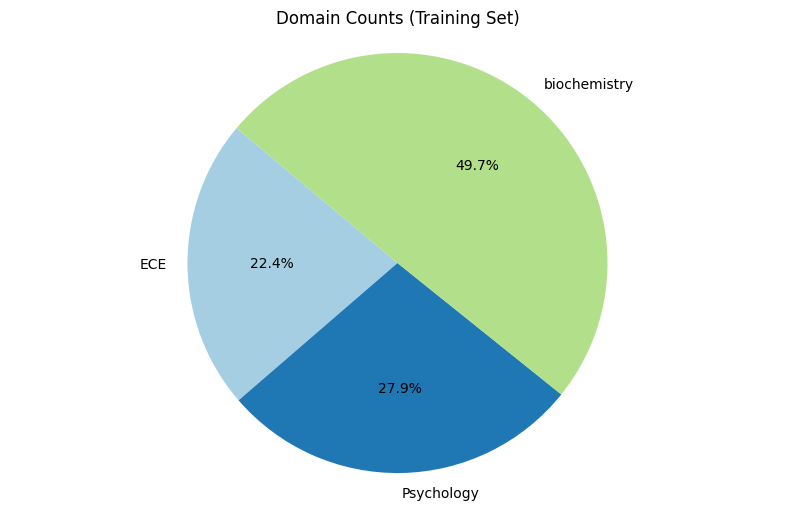

The domain ECE has 1030 records in the training set.
The domain Psychology has 1280 records in the training set.
The domain biochemistry has 2278 records in the training set.


In [ ]:
labels = np.unique(domainsTrain, return_counts=True)[0]
labelCounts =  np.unique(domainsTrain, return_counts=True)[1]

print("Labels ", labels)
print("Label counts ", labelCounts)

nAbstract = len(abstractsTrain)
plt.figure(figsize=(10, 6))
plt.title("Domain Counts (Training Set)")
plt.pie(labelCounts, labels=labels, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired(range(len(labels))))
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

for i, domain in enumerate(labels):
    print("The domain", domain, "has", labelCounts[i], "records in the training set.")

In [ ]:
abstractsTest = test_data[:,3]
keywordsTest = test_data[:,2]
domainsTest = test_data[:,1]
allLabelsTest = test_data[:,0]

print("Number of abstracts: ",len(abstractsTest))
print("Shape of abstracts: ",np.shape(abstractsTest))
print("Number of keywords: ",len(keywordsTest))
print("Shape of keywords: ",np.shape(keywordsTest))
print("Number of domains: ",len(domainsTest))
print("Shape of domains: ",np.shape(domainsTest))
print("Number of labels: ",len(allLabelsTest))
print("Shape of labels: ",np.shape(allLabelsTest))

# arr = np.array(domainsTest)
# cleaned_domains = np.char.strip(arr)
# print("Cleaned arr ", cleaned_domains)
# domainsLabelsTest = cleaned_domains
# print("Labels domains ", domainsLabelsTest)

print(abstractsTest[0:2])
print(keywordsTest[0:2])
print(domainsTest[0:2])
print(allLabelsTest[0:2])

Number of abstracts:  1148
Shape of abstracts:  (1148,)
Number of keywords:  1148
Shape of keywords:  (1148,)
Number of domains:  1148
Shape of domains:  (1148,)
Number of labels:  1148
Shape of labels:  (1148,)
['background aloe vera a v have been used traditionally for topical treatment of wounds and burns in different countries for centuries but the mechanism of this effect is not well understood various growth factors are implicated in the process of wound healing among the different growth factors involved in the process tgf beta 1 and bfgf are the most importantly expressed in fibroblast cells the aim of this study was to evaluate the effect of a v on the expression of angiogenesis growth factors in mouse embryonic fibroblast cells methods we exposed mouse embryonic fibroblast cells to different concentrations of a v 50 100 and 150 mu gml at two different time of 12 and 24 h fibroblast cell without a v treatment serves as the control the expression of tgf beta 1 and bfgf was meas

Labels  ['ECE' 'Psychology' 'biochemistry']
Label counts  [262 317 569]


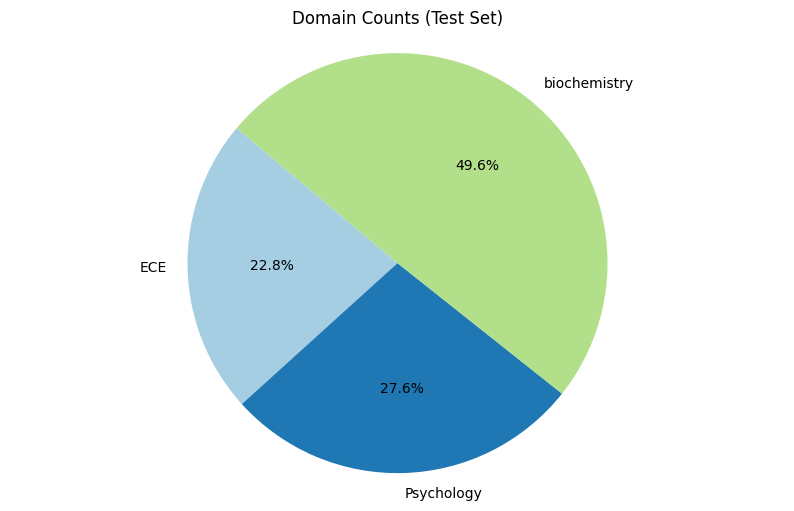

The domain ECE has 262 records in the test set.
The domain Psychology has 317 records in the test set.
The domain biochemistry has 569 records in the test set.


In [ ]:
labels = np.unique(domainsTest, return_counts=True)[0]
labelCounts =  np.unique(domainsTest, return_counts=True)[1]

print("Labels ", labels)
print("Label counts ", labelCounts)

nAbstract = len(abstractsTest)
plt.figure(figsize=(10, 6))
plt.title("Domain Counts (Test Set)")
plt.pie(labelCounts, labels=labels, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired(range(len(labels))))
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

for i, domain in enumerate(labels):
    print("The domain", domain, "has", labelCounts[i], "records in the test set.")

In [ ]:
abstractsVal = val_data[:,3]
keywordsVal = val_data[:,2]
domainsVal = val_data[:,1]
allLabelsVal = val_data[:,0]

print("Number of abstracts: ",len(abstractsVal))
print("Shape of abstracts: ",np.shape(abstractsVal))
print("Number of keywords: ",len(keywordsVal))
print("Shape of keywords: ",np.shape(keywordsVal))
print("Number of domains: ",len(domainsVal))
print("Shape of domains: ",np.shape(domainsVal))
print("Number of labels: ",len(allLabelsVal))
print("Shape of labels: ",np.shape(allLabelsVal))

print(abstractsVal[0:2])
print(keywordsVal[0:2])
print(domainsVal[0:2])
print(allLabelsVal[0:2])

Number of abstracts:  230
Shape of abstracts:  (230,)
Number of keywords:  230
Shape of keywords:  (230,)
Number of domains:  230
Shape of domains:  (230,)
Number of labels:  230
Shape of labels:  (230,)
['mesenteric lymph is vital for immune cell trafficking and intestinal fluid and chyle transport which aid homeostatic maintenance there have been few reports investigating the profiles and circulatory dynamics of mesenteric lymph micrornas mirnas the present study aimed to provide a comprehensive analysis of mirnas in normal rodent mesenteric lymph reverse transcriptionquantitative polymerase chain reaction rtqpcrbased array analysis was performed to examine the expression levels of 375 mirnas in normal rat mesenteric lymph using differential centrifugation the presence of mir150 a representative lymph mirna in exosomes was assessed rat small intestine epithelial cell line iec6derived exosomes were prepared from culture supernatants of cells transfected with celmir2383p and were used 

Labels  ['ECE' 'Psychology' 'biochemistry']
Label counts  [ 53  71 106]


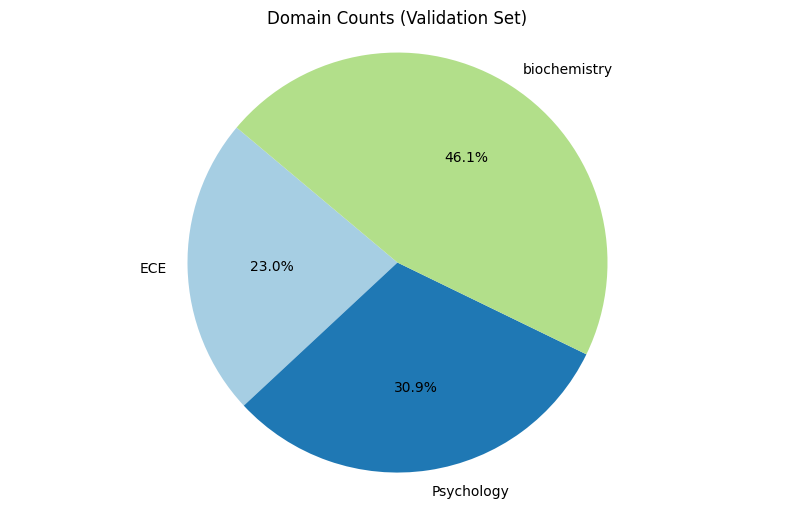

The domain ECE has 53 records in the vaidation set.
The domain Psychology has 71 records in the vaidation set.
The domain biochemistry has 106 records in the vaidation set.


In [ ]:
labels = np.unique(domainsVal, return_counts=True)[0]
labelCounts =  np.unique(domainsVal, return_counts=True)[1]

print("Labels ", labels)
print("Label counts ", labelCounts)

nAbstract = len(abstractsVal)
plt.figure(figsize=(10, 6))
plt.title("Domain Counts (Validation Set)")
plt.pie(labelCounts, labels=labels, autopct='%1.1f%%', startangle=140, colors=plt.cm.Paired(range(len(labels))))
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

for i, domain in enumerate(labels):
    print("The domain", domain, "has", labelCounts[i], "records in the vaidation set.")

In [ ]:
# Function to tokenize and encode the dataset
def encode_data(data, tokenizer, max_length=128):
    # print(len(data[:,2]))
    inputs = tokenizer(
        data[:,3].tolist(), # abstract
        max_length=max_length,
        padding='max_length',
        truncation=True,
        return_tensors="pt"
    )
    # print(len(dataShuffled[:, 0]))
    labels = torch.tensor(data[:, 0].astype(int))
    print("Label length ", len(labels))
    return TensorDataset(inputs['input_ids'], inputs['attention_mask'], labels)

In [ ]:
print(np.shape(train_data))
print(np.shape(test_data))
print(np.shape(val_data))


(4588, 4)
(1148, 4)
(230, 4)


In [ ]:
# Encode training, validation, and testing data
train_dataset = encode_data(train_data, tokenizer)
val_dataset = encode_data(val_data, tokenizer)
test_dataset = encode_data(test_data, tokenizer)



# Data loaders
train_dataloader = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=32)
val_dataloader = DataLoader(val_dataset, sampler=SequentialSampler(val_dataset), batch_size=32)
test_dataloader = DataLoader(test_dataset, sampler=SequentialSampler(test_dataset), batch_size=32)

Label length  4588
Label length  230
Label length  1148


In [ ]:
print(np.unique(train_data[:,0]))

['0' '1' '2']


In [ ]:
# Load SciBERT model
print(len(np.unique(train_data[:,0])))
model = AutoModelForSequenceClassification.from_pretrained("allenai/scibert_scivocab_uncased", num_labels=len(np.unique(train_data[:,0])))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

3


pytorch_model.bin:   0%|          | 0.00/442M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at allenai/scibert_scivocab_uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(31090, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
model.config

BertConfig {
  "_name_or_path": "allenai/scibert_scivocab_uncased",
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.42.4",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 31090
}

In [ ]:
# Optimizer and learning rate scheduler
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)
total_steps = len(train_dataloader) * 20
num_warmup_steps = 1e-4
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=total_steps)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
def calculate_metrics(valType, predictions, true_labels):
    # Confusion matrix
    if(valType == 'test'):
        cm = confusion_matrix(true_labels, predictions)
        print("Confusion Matrix:\n", cm)

        # Classification report (includes precision, recall, F1 score)
        report = classification_report(true_labels, predictions, target_names=[str(i) for i in range(len(np.unique(true_labels)))])
        print("\nClassification Report:\n", report)

        # Calculate different types of F1 scores, precision, and recall
        f1_macro = f1_score(true_labels, predictions, average='macro')
        f1_micro = f1_score(true_labels, predictions, average='micro')
        f1_weighted = f1_score(true_labels, predictions, average='weighted')

        precision_macro = precision_score(true_labels, predictions, average='macro')
        precision_micro = precision_score(true_labels, predictions, average='micro')
        precision_weighted = precision_score(true_labels, predictions, average='weighted')

        recall_macro = recall_score(true_labels, predictions, average='macro')
        recall_micro = recall_score(true_labels, predictions, average='micro')
        recall_weighted = recall_score(true_labels, predictions, average='weighted')

        print(f"Macro F1 Score: {f1_macro}")
        print(f"Micro F1 Score: {f1_micro}")
        print(f"Weighted F1 Score: {f1_weighted}")

        print(f"Macro Precision: {precision_macro}")
        print(f"Micro Precision: {precision_micro}")
        print(f"Weighted Precision: {precision_weighted}")

        print(f"Macro Recall: {recall_macro}")
        print(f"Micro Recall: {recall_micro}")
        print(f"Weighted Recall: {recall_weighted}")

    elif(valType == 'val'):
        cm = confusion_matrix(true_labels, predictions)
        f1_macro = f1_score(true_labels, predictions, average='macro')
        f1_micro = f1_score(true_labels, predictions, average='micro')
        f1_weighted = f1_score(true_labels, predictions, average='weighted')

        precision_macro = precision_score(true_labels, predictions, average='macro')
        precision_micro = precision_score(true_labels, predictions, average='micro')
        precision_weighted = precision_score(true_labels, predictions, average='weighted')

        recall_macro = recall_score(true_labels, predictions, average='macro')
        recall_micro = recall_score(true_labels, predictions, average='micro')
        recall_weighted = recall_score(true_labels, predictions, average='weighted')
        # print('Val Micro F1:', f1_micro)
        return f1_micro

In [ ]:
epochs = 20
for epoch in range(epochs):
    model.train()
    total_train_loss = 0
    start_time = time.time()

    # Training
    for step, batch in enumerate(tqdm(train_dataloader, desc=f"Epoch {epoch + 1}/{epochs}", unit="batch")):
        batch = tuple(t.to(device) for t in batch)
        input_ids, input_mask, labels = batch


        model.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=input_mask, labels=labels)
        loss = outputs.loss
        total_train_loss += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_train_loss / len(train_dataloader)

    # Validation
    model.eval()
    predictions = []
    true_labels = []

    for batch in val_dataloader:
        batch = tuple(t.to(device) for t in batch)
        input_ids, input_mask, labels = batch

        with torch.no_grad():
            outputs = model(input_ids=input_ids, attention_mask=input_mask)
            logits = outputs.logits

        logits = logits.detach().cpu().numpy()
        label_ids = labels.to('cpu').numpy()

        batch_predictions = np.argmax(logits, axis=1)
        predictions.extend(batch_predictions)
        true_labels.extend(label_ids)

    val_micro_f1 = calculate_metrics('val', predictions, true_labels)
    elapsed_time = time.time() - start_time

    # Print epoch summary
    print(f"Epoch {epoch + 1}/{epochs}")
    print(f"  Train Loss: {avg_train_loss}")
    print(f"  Val Micro F1: {val_micro_f1}")
    print(f"  Time: {elapsed_time // 60:.0f}m {elapsed_time % 60:.0f}s")

Epoch 1/20: 100%|██████████| 144/144 [01:31<00:00,  1.58batch/s]


Epoch 1/20
  Train Loss: 0.24899757756955093
  Val Micro F1: 0.9478260869565217
  Time: 1m 33s


Epoch 2/20: 100%|██████████| 144/144 [01:35<00:00,  1.50batch/s]


Epoch 2/20
  Train Loss: 0.07754695821656948
  Val Micro F1: 0.9739130434782609
  Time: 1m 37s


Epoch 3/20: 100%|██████████| 144/144 [01:35<00:00,  1.51batch/s]


Epoch 3/20
  Train Loss: 0.032870362459410295
  Val Micro F1: 0.9565217391304348
  Time: 1m 37s


Epoch 4/20: 100%|██████████| 144/144 [01:35<00:00,  1.50batch/s]


Epoch 4/20
  Train Loss: 0.00853056496554119
  Val Micro F1: 0.9652173913043478
  Time: 1m 37s


Epoch 5/20: 100%|██████████| 144/144 [01:35<00:00,  1.50batch/s]


Epoch 5/20
  Train Loss: 0.005717325429335081
  Val Micro F1: 0.9695652173913043
  Time: 1m 37s


Epoch 6/20: 100%|██████████| 144/144 [01:35<00:00,  1.51batch/s]


Epoch 6/20
  Train Loss: 0.00235505405988887
  Val Micro F1: 0.9739130434782609
  Time: 1m 37s


Epoch 7/20: 100%|██████████| 144/144 [01:35<00:00,  1.51batch/s]


Epoch 7/20
  Train Loss: 0.001585157118825009
  Val Micro F1: 0.9695652173913043
  Time: 1m 37s


Epoch 8/20: 100%|██████████| 144/144 [01:35<00:00,  1.51batch/s]


Epoch 8/20
  Train Loss: 0.0014929793589746826
  Val Micro F1: 0.9739130434782609
  Time: 1m 37s


Epoch 9/20: 100%|██████████| 144/144 [01:35<00:00,  1.51batch/s]


Epoch 9/20
  Train Loss: 0.00015942544526600008
  Val Micro F1: 0.9739130434782609
  Time: 1m 37s


Epoch 10/20: 100%|██████████| 144/144 [01:35<00:00,  1.51batch/s]


Epoch 10/20
  Train Loss: 0.00012809714219959764
  Val Micro F1: 0.9739130434782609
  Time: 1m 37s


Epoch 11/20: 100%|██████████| 144/144 [01:35<00:00,  1.51batch/s]


Epoch 11/20
  Train Loss: 0.00011045538985854364
  Val Micro F1: 0.9739130434782609
  Time: 1m 37s


Epoch 12/20: 100%|██████████| 144/144 [01:35<00:00,  1.51batch/s]


Epoch 12/20
  Train Loss: 9.52356376223583e-05
  Val Micro F1: 0.9739130434782609
  Time: 1m 37s


Epoch 13/20: 100%|██████████| 144/144 [01:35<00:00,  1.51batch/s]


Epoch 13/20
  Train Loss: 8.540084410116024e-05
  Val Micro F1: 0.9739130434782609
  Time: 1m 37s


Epoch 14/20: 100%|██████████| 144/144 [01:35<00:00,  1.51batch/s]


Epoch 14/20
  Train Loss: 7.764908264107362e-05
  Val Micro F1: 0.9739130434782609
  Time: 1m 37s


Epoch 15/20: 100%|██████████| 144/144 [01:35<00:00,  1.51batch/s]


Epoch 15/20
  Train Loss: 7.331480489685621e-05
  Val Micro F1: 0.9739130434782609
  Time: 1m 37s


Epoch 16/20: 100%|██████████| 144/144 [01:35<00:00,  1.51batch/s]


Epoch 16/20
  Train Loss: 6.904851981441122e-05
  Val Micro F1: 0.9739130434782609
  Time: 1m 37s


Epoch 17/20: 100%|██████████| 144/144 [01:35<00:00,  1.50batch/s]


Epoch 17/20
  Train Loss: 6.491603461553395e-05
  Val Micro F1: 0.9739130434782609
  Time: 1m 37s


Epoch 18/20: 100%|██████████| 144/144 [01:35<00:00,  1.51batch/s]


Epoch 18/20
  Train Loss: 6.286243961363248e-05
  Val Micro F1: 0.9739130434782609
  Time: 1m 37s


Epoch 19/20: 100%|██████████| 144/144 [01:35<00:00,  1.51batch/s]


Epoch 19/20
  Train Loss: 6.13437157931508e-05
  Val Micro F1: 0.9739130434782609
  Time: 1m 37s


Epoch 20/20: 100%|██████████| 144/144 [01:35<00:00,  1.51batch/s]


Epoch 20/20
  Train Loss: 6.04742388077284e-05
  Val Micro F1: 0.9739130434782609
  Time: 1m 37s


In [ ]:
# Evaluation
model.eval()
predictions = []
true_labels = []

for batch in test_dataloader:
    batch = tuple(t.to(device) for t in batch)
    input_ids, input_mask, labels = batch

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=input_mask)
        logits = outputs.logits

    logits = logits.detach().cpu().numpy()
    label_ids = labels.to('cpu').numpy()

    batch_predictions = np.argmax(logits, axis=1)
    predictions.extend(batch_predictions)
    true_labels.extend(label_ids)

# Calculate and print metrics
calculate_metrics('test', predictions, true_labels)

Confusion Matrix:
 [[254   5   3]
 [  3 303  11]
 [  0   6 563]]

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.97      0.98       262
           1       0.96      0.96      0.96       317
           2       0.98      0.99      0.98       569

    accuracy                           0.98      1148
   macro avg       0.98      0.97      0.97      1148
weighted avg       0.98      0.98      0.98      1148

Macro F1 Score: 0.9739112455541651
Micro F1 Score: 0.975609756097561
Weighted F1 Score: 0.9755726411484135
Macro Precision: 0.9763438565242696
Micro Precision: 0.975609756097561
Weighted Precision: 0.9756364513520763
Macro Recall: 0.9715855985114477
Micro Recall: 0.975609756097561
Weighted Recall: 0.975609756097561


In [ ]:
model.save_pretrained('/content/drive/MyDrive/WoS/SciBERT_WoS_Abstracts_5736')